In [7]:
import pandas as pd
import numpy as np
from glob import glob
from re import match, sub
from missingno import matrix as mmatrix
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from math import ceil
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
from os import listdir

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [8]:
# %%html
# <style>
#     .jp-WindowedPanel-outer {
#         padding: 0% 10% !important;
#     }
#     .jp-RenderedImage img {
#         width: 50%;
#         transform: translateX(-75%);
#         margin-left: 50%;
#     }
# </style>


In [9]:
if 'figure_dir.txt' in listdir():
    with open('figure_dir.txt', 'r') as f:
        fig_dir = f.readline().strip().replace('\\', '/')
        tbl_dir = f"{fig_dir.rsplit('/', maxsplit=2)[0]}/Tables/"
else:
    fig_dir = 'Figures/'
    tbl_dir = 'Tables/'

def trim_trailing_zeros(number_string):
    '''
    Take a string with numbers and remove any trailing zeros from the number.
    '''
    return sub(
        r'(?:\.0+|(\.\d+)0+)(%?)$', 
        '\\1\\2', number_string
    )

def neaten_ticks(
        ax, axis, tick_range, ticks, dp=0, fmt='f', twin=False
    ):
    '''
    Take a plot ax and convert its x or y axis into a neatened range frame.
    '''
    # Set sets.
    eval(f"ax.set_{axis}ticks")(sorted([*ticks, *tick_range]))
    is_log = eval(f"ax.get_{axis}scale")() == 'log' 
    # Set labels.
    eval(f"ax.set_{axis}ticklabels")([
        f"$\\mathdefault{{10^{{{ex:.0f}}}}}$" 
        if is_log and int((ex := np.log10(e))) == ex 
        else trim_trailing_zeros(eval(f'''f"{{e:.0{dp}{fmt}}}"'''))
        for e in eval(f"ax.get_{axis}ticks")()
    ])
    # Limit axis outline to data range.
    ax.spines[
        'right' if twin else 'bottom' if axis == 'x' else 'left'
    ].set_bounds(*tick_range)

def show(
    fig, axes=[], tight=False, despine=True, despine_twin=False, 
    delax=True, file=None, legend_loc=0, filetype='pdf'
):
    '''Style and show a matplotlib plot.'''
    if tight: plt.tight_layout() # Neaten subplots.
    # Remove unnecessary outlines from plots with twin axes.
    # Note that this method assumes all axes have twins.
    if despine_twin:
        for ax in axes[::2]:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        for ax in axes[1::2]:
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
    # Remove unnecessary outlines.
    elif despine:
        for ax in axes:
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    for ax in axes:
    # Remove unused subplots.
        if delax and not ax.has_data(): fig.delaxes(ax)
        ax.tick_params(
            axis='both', which='minor', 
            bottom=False, left=False, right=False
        )
        # Style the legend if a legend is present.
        if ax.get_legend():
            handles, labels = ax.get_legend_handles_labels()
            labels = [e.title() for e in labels]
            legend_title = ax.get_legend().get_title().get_text().title()
            ax.legend(
                handles=handles, labels=labels, 
                title=legend_title, loc=legend_loc
            )
    # Save file if a filename is provided.
    if file:
        plt.savefig(
            f'{fig_dir}/Plots/{file}.{filetype}', dpi = 300,
            bbox_inches = 'tight', pad_inches = 1/25
        )
    plt.show()
    

In [10]:
df = pd.read_csv('data/modelling_data.csv', parse_dates=['DATETIME'], date_format='%Y-%m-%d %H:%M:%S')

df


,DATETIME,TEMPERATURE,state,TOTALDEMAND,REGIONID,hour,month,year,day_label,is_weekday,...,h1_ahead,h1_hour,h1_day,h1_month,h1_year,h24_ahead,h24_hour,h24_day,h24_month,h24_year
0,2010-01-01 00:00:00,23.1,NSW,8038.00,NSW1,0,1,2010,Fri,True,...,7483.69,1.0,5.0,1.0,2010.0,7574.85,0.0,6.0,1.0,2010.0
1,2010-01-01 00:30:00,22.9,NSW,7809.31,NSW1,0,1,2010,Fri,True,...,7117.23,1.0,5.0,1.0,2010.0,7343.30,0.0,6.0,1.0,2010.0
2,2010-01-01 01:00:00,22.6,NSW,7483.69,NSW1,1,1,2010,Fri,True,...,6812.03,2.0,5.0,1.0,2010.0,7099.73,1.0,6.0,1.0,2010.0
3,2010-01-01 01:30:00,22.5,NSW,7117.23,NSW1,1,1,2010,Fri,True,...,6544.33,2.0,5.0,1.0,2010.0,6779.80,1.0,6.0,1.0,2010.0
4,2010-01-01 02:00:00,22.5,NSW,6812.03,NSW1,2,1,2010,Fri,True,...,6377.32,3.0,5.0,1.0,2010.0,6497.47,2.0,6.0,1.0,2010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195207,2021-03-16 22:00:00,20.4,NSW,7373.83,NSW1,22,3,2021,Tue,True,...,7218.99,23.0,2.0,3.0,2021.0,7419.77,22.0,3.0,3.0,2021.0
195208,2021-03-16 22:30:00,20.5,NSW,7345.78,NSW1,22,3,2021,Tue,True,...,7056.88,23.0,2.0,3.0,2021.0,7417.91,22.0,3.0,3.0,2021.0
195209,2021-03-16 23:00:00,20.3,NSW,7218.99,NSW1,23,3,2021,Tue,True,...,6999.23,0.0,3.0,3.0,2021.0,7287.32,23.0,3.0,3.0,2021.0
195210,2021-03-16 23:30:00,19.7,NSW,7056.88,NSW1,23,3,2021,Tue,True,...,6849.85,0.0,3.0,3.0,2021.0,7172.39,23.0,3.0,3.0,2021.0


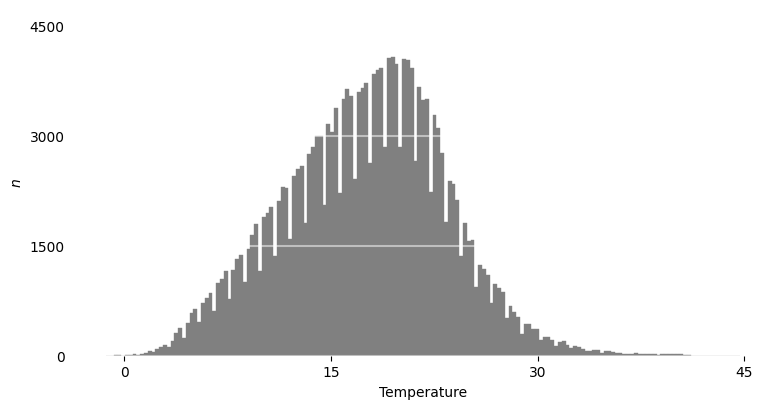

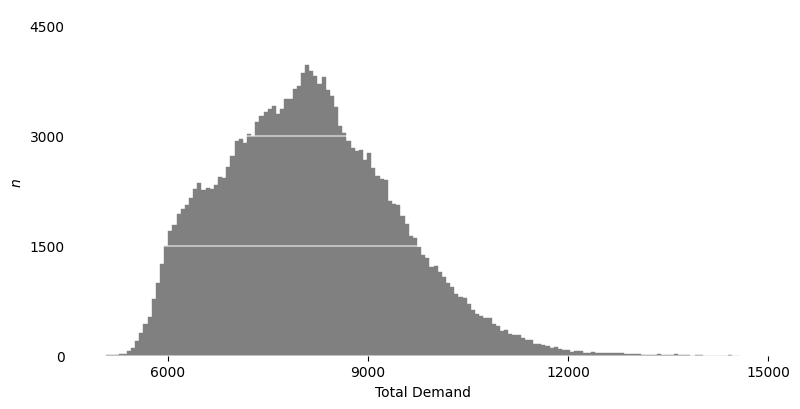

In [11]:
for col in ['Temperature', 'Total Demand']:
    fig, ax = plt.subplots(figsize=(9, 4.5))
    col_label = col.replace(' ', '').upper()
    
    # df.TEMPERATURE.hist(ax = ax)
    sns.histplot(df, x=col_label, color='grey', edgecolor='grey', alpha=1)
    
    ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(4))
    ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
    for line in ax.get_yticks():
        ax.axhline(line, 0, max(ax.get_xticks()), color='white', alpha=0.5)
    
    for side in ax.spines:
        ax.spines[side].set_visible(False)
    
    ax.tick_params(axis='y', color='white')
    ax.set_xlabel(col)
    ax.set_ylabel('$n$')
    
    show(fig, [ax], file=f'{col} histogram')


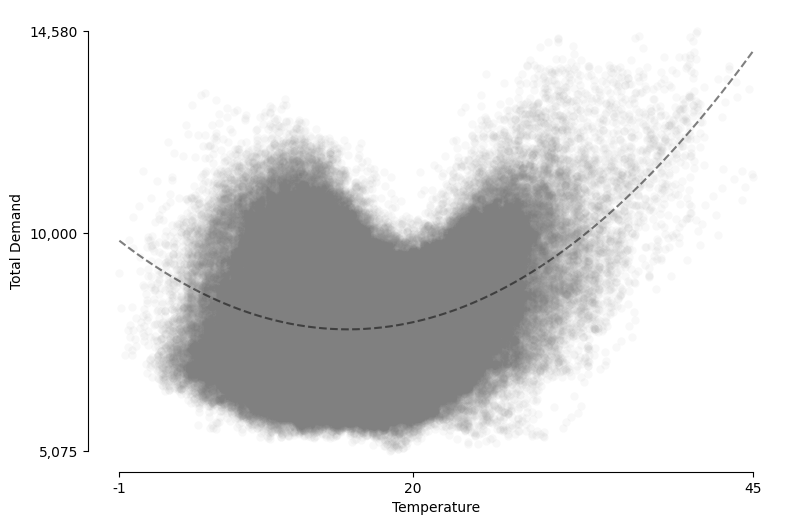

In [12]:
dvt_model = ols("TOTALDEMAND ~ TEMPERATURE + I(TEMPERATURE**2)", df).fit()
lobf_X = np.linspace(min(df.TEMPERATURE), max(df.TEMPERATURE), 1000)
lobf_y =  dvt_model.predict(pd.Series(lobf_X, name='TEMPERATURE'))

fig, ax = plt.subplots(figsize=(9, 6))

sns.scatterplot(
    df, y='TOTALDEMAND', x='TEMPERATURE', ax=ax,
    alpha=0.05, c='grey', lw=0, edgecolor='grey'
)
ax.plot(lobf_X, lobf_y, ls='--', c='black', alpha=.5)

ax.set_xlabel('Temperature')
ax.set_ylabel('Total Demand')

neaten_ticks(ax, 'x', [df.TEMPERATURE.min(), df.TEMPERATURE.max()], [20])
neaten_ticks(ax, 'y', [df.TOTALDEMAND.min(), df.TOTALDEMAND.max()], [1e4])

ax.set_yticklabels([f"{e:,.0f}" for e in ax.get_yticks()])

show(fig, [ax], file=f'Total demand vs. temperature scatterplot', filetype='png')


In [16]:
# fig, ax = plt.subplots(figsize=(9, 4.5))
# col_label = col.replace(' ', '').upper()

# sns.histplot(fore, x='FORECASTDEMAND', color='grey', edgecolor='grey', alpha=1)

# ax.xaxis.set_major_locator(ticker.MaxNLocator(3))
# ax.yaxis.set_major_locator(ticker.MaxNLocator(3))
# ax.yaxis.set_major_locator(ticker.FixedLocator(ax.get_yticks()))
# for line in ax.get_yticks():
#     ax.axhline(line, 0, max(ax.get_xticks()), color='white', alpha=0.5)
    
# ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
# ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# for side in ax.spines:
#     ax.spines[side].set_visible(False)

# ax.tick_params(axis='y', color='white')
# ax.set_xlabel('Forecast Demand')
# ax.set_ylabel('$n$')

# show(fig, [ax], file=f'Forecast demand histogram')


In [21]:
# fig, axes = plt.subplots(1, 2, figsize=(18, 6))
# axes = axes.flatten()

# hours_ahead = [2, 48]
# for i, period in enumerate(hours_ahead):
#     ax = axes[i]
#     data = pd.merge(df, fore[fore.PERIODID == period][['DATETIME', 'state', 'FORECASTDEMAND']], how='left', on=['DATETIME', 'state'])\
#         .dropna().reset_index(drop=True)

#     x, y ='TOTALDEMAND', 'FORECASTDEMAND'
#     sns.scatterplot(data, x=x, y=y, ax=ax, alpha=0.05, c='grey')
#     corr = pearsonr(data[x], data[y]).statistic
#     ax.text(0.05, .9, f"R={corr:.04f}", transform=ax.transAxes, fontsize=14)
    
#     ax.set_title(f"{period//2}H head", loc='right', fontweight=600)
#     ax.set_xlabel('Total Demand')
#     ax.set_ylabel('Forecast Demand')

#     neaten_ticks(ax, 'x', [data.TOTALDEMAND.min(), data.TOTALDEMAND.max()], [1e4])
#     neaten_ticks(ax, 'y', [data.FORECASTDEMAND.min(), data.FORECASTDEMAND.max()], [1e4])

#     ax.set_xticklabels([f"{e:,.0f}" for e in ax.get_xticks()])
#     ax.set_yticklabels([f"{e:,.0f}" for e in ax.get_yticks()])

# show(fig, axes, file=f'Forecast vs. actual for 1- and 24-hours', legend_loc=0, filetype='png')



In [22]:
# corrs = []
# for i in range(min(hours_ahead), max(hours_ahead)+1):
#     data = pd.merge(df, fore[fore.PERIODID == i][['DATETIME', 'state', 'FORECASTDEMAND']], how='left', on=['DATETIME', 'state'])\
#         .dropna().reset_index(drop=True)
#     corr = pearsonr(data[x], data[y]).statistic
#     corrs.append({'PERIODID': i, 'correlation': corr})

# data = pd.DataFrame(corrs).sort_values('PERIODID')

# fig, ax = plt.subplots(figsize=(9, 6))

# data.plot(ax=ax, x='PERIODID', c='grey', alpha=1)

# neaten_ticks(ax, 'x', [data.PERIODID.min(), data.PERIODID.max()], [])
# neaten_ticks(ax, 'y', [data.correlation.min(), data.correlation.max()], [.99], dp=4)
# ax.get_legend().remove()
# ax.set_xlabel('Period ID')
# ax.set_ylabel('Correlation')

# show(fig, [ax], file=f'Forecast vs. actual correlation by Period ID', legend_loc=0)


In [28]:
# data = df.groupby(['day', 'day_label']).TOTALDEMAND.apply(list).sort_index(ascending=False)
# medians = data.apply(np.median)

# fig, ax = plt.subplots(figsize=(9, 3))

# bplot = ax.boxplot(
#     x=data, vert=False, labels = [e[1] for e in data.index], showbox=False,
#     medianprops={'linewidth': 0}, whis=5, showcaps=False,
# )
# ax.scatter(medians, range(1, len(medians.index)+1), s=10, c='black')

# ax.set_xlabel('Total Demand')

# neaten_ticks(ax, 'x', [
#     data.explode().to_frame().min().squeeze(), 
#     data.explode().to_frame().max().squeeze()
# ], [])

# ax.spines['left'].set_visible(False)
# ax.tick_params(axis='y', which='major', left=False)

# show(fig, [ax], file='Demand by day boxplots')


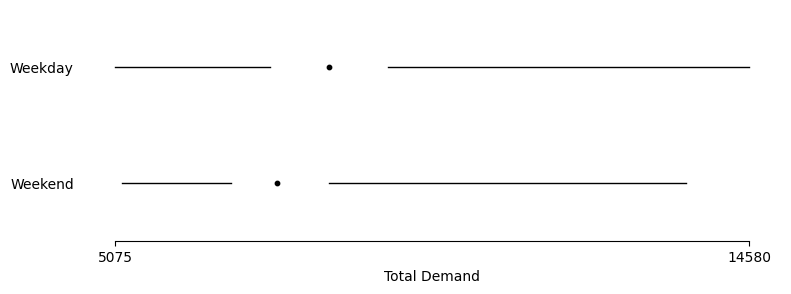

In [29]:
data = df.groupby('is_weekday').TOTALDEMAND.apply(list).sort_index()
medians = data.apply(np.median)

fig, ax = plt.subplots(figsize=(9, 3))

ax.boxplot(
    x=data, vert=False, labels = ['Weekday' if e else 'Weekend' for e in data.index], showbox=False,
    medianprops={'linewidth': 0}, whis=5, showcaps=False
)
ax.scatter(medians, range(1, len(medians.index)+1), s=10, c='black')

ax.set_xlabel('Total Demand')

neaten_ticks(ax, 'x', [
    data.explode().to_frame().min().squeeze(), 
    data.explode().to_frame().max().squeeze()
], [])

ax.spines['left'].set_visible(False)
ax.tick_params(axis='y', which='major', left=False)

show(fig, [ax], file='Demand by is-weekend boxplots')
